<a href="https://colab.research.google.com/github/wootaehyeon/AI_lab/blob/main/AI10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [31]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

import zipfile

data_dir = '/content/hymenoptera_data.zip'
extracted_dir = '/content/hymenoptera_data'

# Unzip the data if it hasn't been unzipped yet
if not os.path.exists(extracted_dir):
    with zipfile.ZipFile(data_dir, 'r') as zip_ref:
        zip_ref.extractall('/content')

image_datasets = {x: datasets.ImageFolder(os.path.join(extracted_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


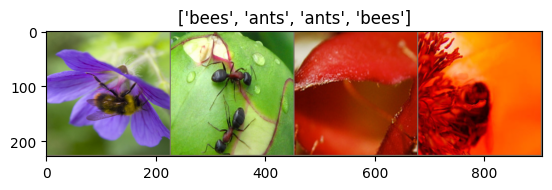

In [32]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1')

# Freeze all the parameters in the network
for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5920 Acc: 0.7049
val Loss: 0.4787 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.4530 Acc: 0.8402
val Loss: 0.3658 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.3931 Acc: 0.8402
val Loss: 0.2998 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4041 Acc: 0.8238
val Loss: 0.2741 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3362 Acc: 0.8607
val Loss: 0.2391 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4252 Acc: 0.8033
val Loss: 0.3817 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.3326 Acc: 0.8525
val Loss: 0.2489 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3025 Acc: 0.8852
val Loss: 0.2940 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3413 Acc: 0.8361
val Loss: 0.2548 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3190 Acc: 0.8443
val Loss: 0.2744 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3055 Acc: 0.8770
val Loss: 0.2967 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3563 Acc: 0.8443
val Loss: 0.2469 Acc: 0.9150

Ep

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.2462 Acc: 0.9085

Epoch 15/24
----------
train Loss: 0.2682 Acc: 0.8975
val Loss: 0.2726 Acc: 0.9085

Epoch 16/24
----------
train Loss: 0.3631 Acc: 0.8361
val Loss: 0.2782 Acc: 0.9020

Epoch 17/24
----------
train Loss: 0.2986 Acc: 0.8689
val Loss: 0.2495 Acc: 0.9150

Epoch 18/24
----------
train Loss: 0.3012 Acc: 0.8525
val Loss: 0.2258 Acc: 0.9216

Epoch 19/24
----------
train Loss: 0.3266 Acc: 0.8525


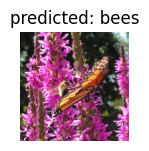

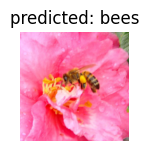

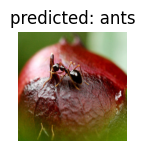

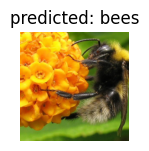

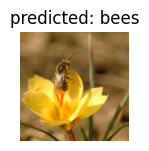

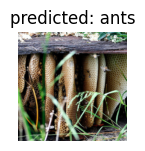

In [13]:
visualize_model(model_ft)

In [14]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6118 Acc: 0.6516
val Loss: 0.2616 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.5134 Acc: 0.7828
val Loss: 0.2226 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4199 Acc: 0.7869
val Loss: 0.2136 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4079 Acc: 0.8279
val Loss: 0.1830 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4122 Acc: 0.7910
val Loss: 0.2701 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4045 Acc: 0.8279
val Loss: 0.1551 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3570 Acc: 0.8443
val Loss: 0.1741 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3800 Acc: 0.8320
val Loss: 0.1717 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.4305 Acc: 0.7992
val Loss: 0.1804 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3279 Acc: 0.8402
val Loss: 0.1782 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3672 Acc: 0.8033
val Loss: 0.1665 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3576 Acc: 0.8361
val Loss: 0.1704 Acc: 0.9608

Ep

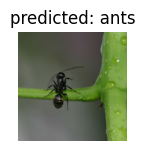

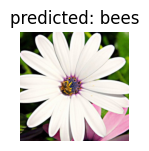

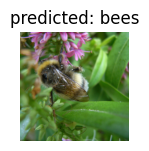

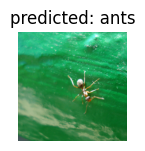

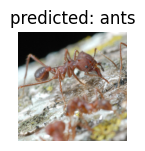

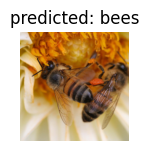

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [17]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

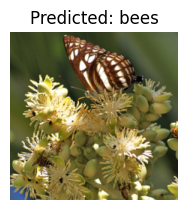

In [20]:
visualize_model_predictions(
    model_conv,
    img_path='/content/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)
plt.ioff()
plt.show()

In [22]:
model_ft = models.efficientnet_b3(weights="IMAGENET1K_V!")#사전학습된 모델 불러오기

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 144MB/s]


In [24]:
model_efficientnet = train_model(model_efficientnet, criterion_efficientnet, optimizer_efficientnet, exp_lr_scheduler_efficientnet,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.5935 Acc: 0.6885
val Loss: 0.4806 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.5012 Acc: 0.7787
val Loss: 0.3855 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4086 Acc: 0.8361
val Loss: 0.3463 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.4015 Acc: 0.8033
val Loss: 0.3059 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.3975 Acc: 0.8443
val Loss: 0.2807 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.4068 Acc: 0.8320
val Loss: 0.2587 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3520 Acc: 0.8484
val Loss: 0.2617 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3299 Acc: 0.8525
val Loss: 0.2677 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.2848 Acc: 0.9098
val Loss: 0.2457 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3242 Acc: 0.8852
val Loss: 0.2427 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3339 Acc: 0.8525
val Loss: 0.2308 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3600 Acc: 0.8566
val Loss: 0.2474 Acc: 0.9150

Epoch 12/24
----------
t

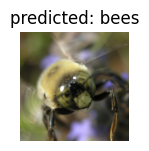

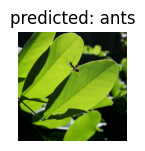

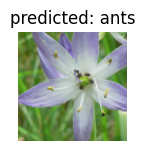

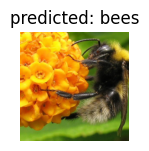

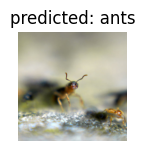

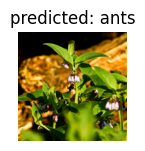

In [25]:
visualize_model(model_efficientnet)

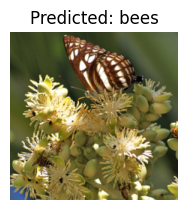

In [26]:
visualize_model_predictions(
    model_efficientnet,
    img_path='/content/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)
plt.ioff()
plt.show()

In [23]:
model_efficientnet = models.efficientnet_b3(weights='IMAGENET1K_V1')
num_ftrs_efficientnet = model_efficientnet.classifier[1].in_features
model_efficientnet.classifier[1] = nn.Linear(num_ftrs_efficientnet, len(class_names))

model_efficientnet = model_efficientnet.to(device)

criterion_efficientnet = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_efficientnet = optim.SGD(model_efficientnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_efficientnet = lr_scheduler.StepLR(optimizer_efficientnet, step_size=7, gamma=0.1)

In [28]:
model_ft = models.efficientnet_b3(weights="IMAGENET1K_V1")#사전학습된 모델 불러오기